# Задача

Необходимо, чтобы модель определяла качественное вино (бинарная классификация)

Качественное: quality = 7/8 \
Некачественное: quality = 3/4/5/6

Метрика: precision

# Библиотеки

In [1]:
import sklearn
print(sklearn.__version__)

1.5.2


In [113]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.pipeline import Pipeline, make_pipeline
from sklearn import svm

from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, Normalizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, validation_curve, train_test_split, KFold,GridSearchCV, StratifiedKFold, RepeatedStratifiedKFold, TunedThresholdClassifierCV, cross_validate
from sklearn.metrics import accuracy_score, classification_report, f1_score, precision_score, recall_score, make_scorer
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay

from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.naive_bayes import GaussianNB

# EDA

In [5]:
path_train = 'train.csv'

In [6]:
train = pd.read_csv(path_train)
print(train.shape)
train

(1295, 12)


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,5.0,0.74,0.00,1.20,0.041,16.0,46.0,0.99258,4.01,0.59,12.5,6
1,11.0,0.26,0.68,2.55,0.085,10.0,25.0,0.99700,3.18,0.61,11.8,5
2,7.3,0.38,0.21,2.00,0.080,7.0,35.0,0.99610,3.33,0.47,9.5,5
3,8.9,0.28,0.45,1.70,0.067,7.0,12.0,0.99354,3.25,0.55,12.3,7
4,9.2,0.41,0.50,2.50,0.055,12.0,25.0,0.99520,3.34,0.79,13.3,7
...,...,...,...,...,...,...,...,...,...,...,...,...
1290,9.5,0.39,0.41,8.90,0.069,18.0,39.0,0.99859,3.29,0.81,10.9,7
1291,8.5,0.34,0.40,4.70,0.055,3.0,9.0,0.99738,3.38,0.66,11.6,7
1292,15.0,0.21,0.44,2.20,0.075,10.0,24.0,1.00005,3.07,0.84,9.2,7
1293,7.5,0.52,0.40,2.20,0.060,12.0,20.0,0.99474,3.26,0.64,11.8,6


In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1295 entries, 0 to 1294
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1294 non-null   float64
 1   volatile acidity      1294 non-null   float64
 2   citric acid           1295 non-null   float64
 3   residual sugar        1295 non-null   float64
 4   chlorides             1295 non-null   float64
 5   free sulfur dioxide   1295 non-null   float64
 6   total sulfur dioxide  1295 non-null   float64
 7   density               1295 non-null   float64
 8   pH                    1294 non-null   float64
 9   sulphates             1293 non-null   float64
 10  alcohol               1295 non-null   float64
 11  quality               1295 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 121.5 KB


train.drop_duplicates(inplace=True)
print(train.shape)

In [12]:
train[train.isna().any(axis=1)]

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
637,6.4,0.530,0.09,3.9,0.123,14.0,31.0,0.99680,3.50,NaN,11.0,4
698,5.9,0.550,0.10,2.2,0.062,39.0,51.0,0.99512,3.52,NaN,11.2,6
720,NaN,0.705,0.10,2.8,0.081,13.0,28.0,0.99631,NaN,0.66,10.2,5
1146,7.2,NaN,0.33,2.5,0.068,34.0,102.0,0.99414,3.27,0.78,12.8,6


Данных с NaN не много ⇒ можно их просто удалить

In [13]:
train.dropna(inplace=True)
print(train.shape)

(1015, 12)


Рассматривать выбросы стоит для каждого уровня качества отдельно, тк могут быть признаки, которые для плохого вина будут выбросами, а для качественного нет и наоборот.

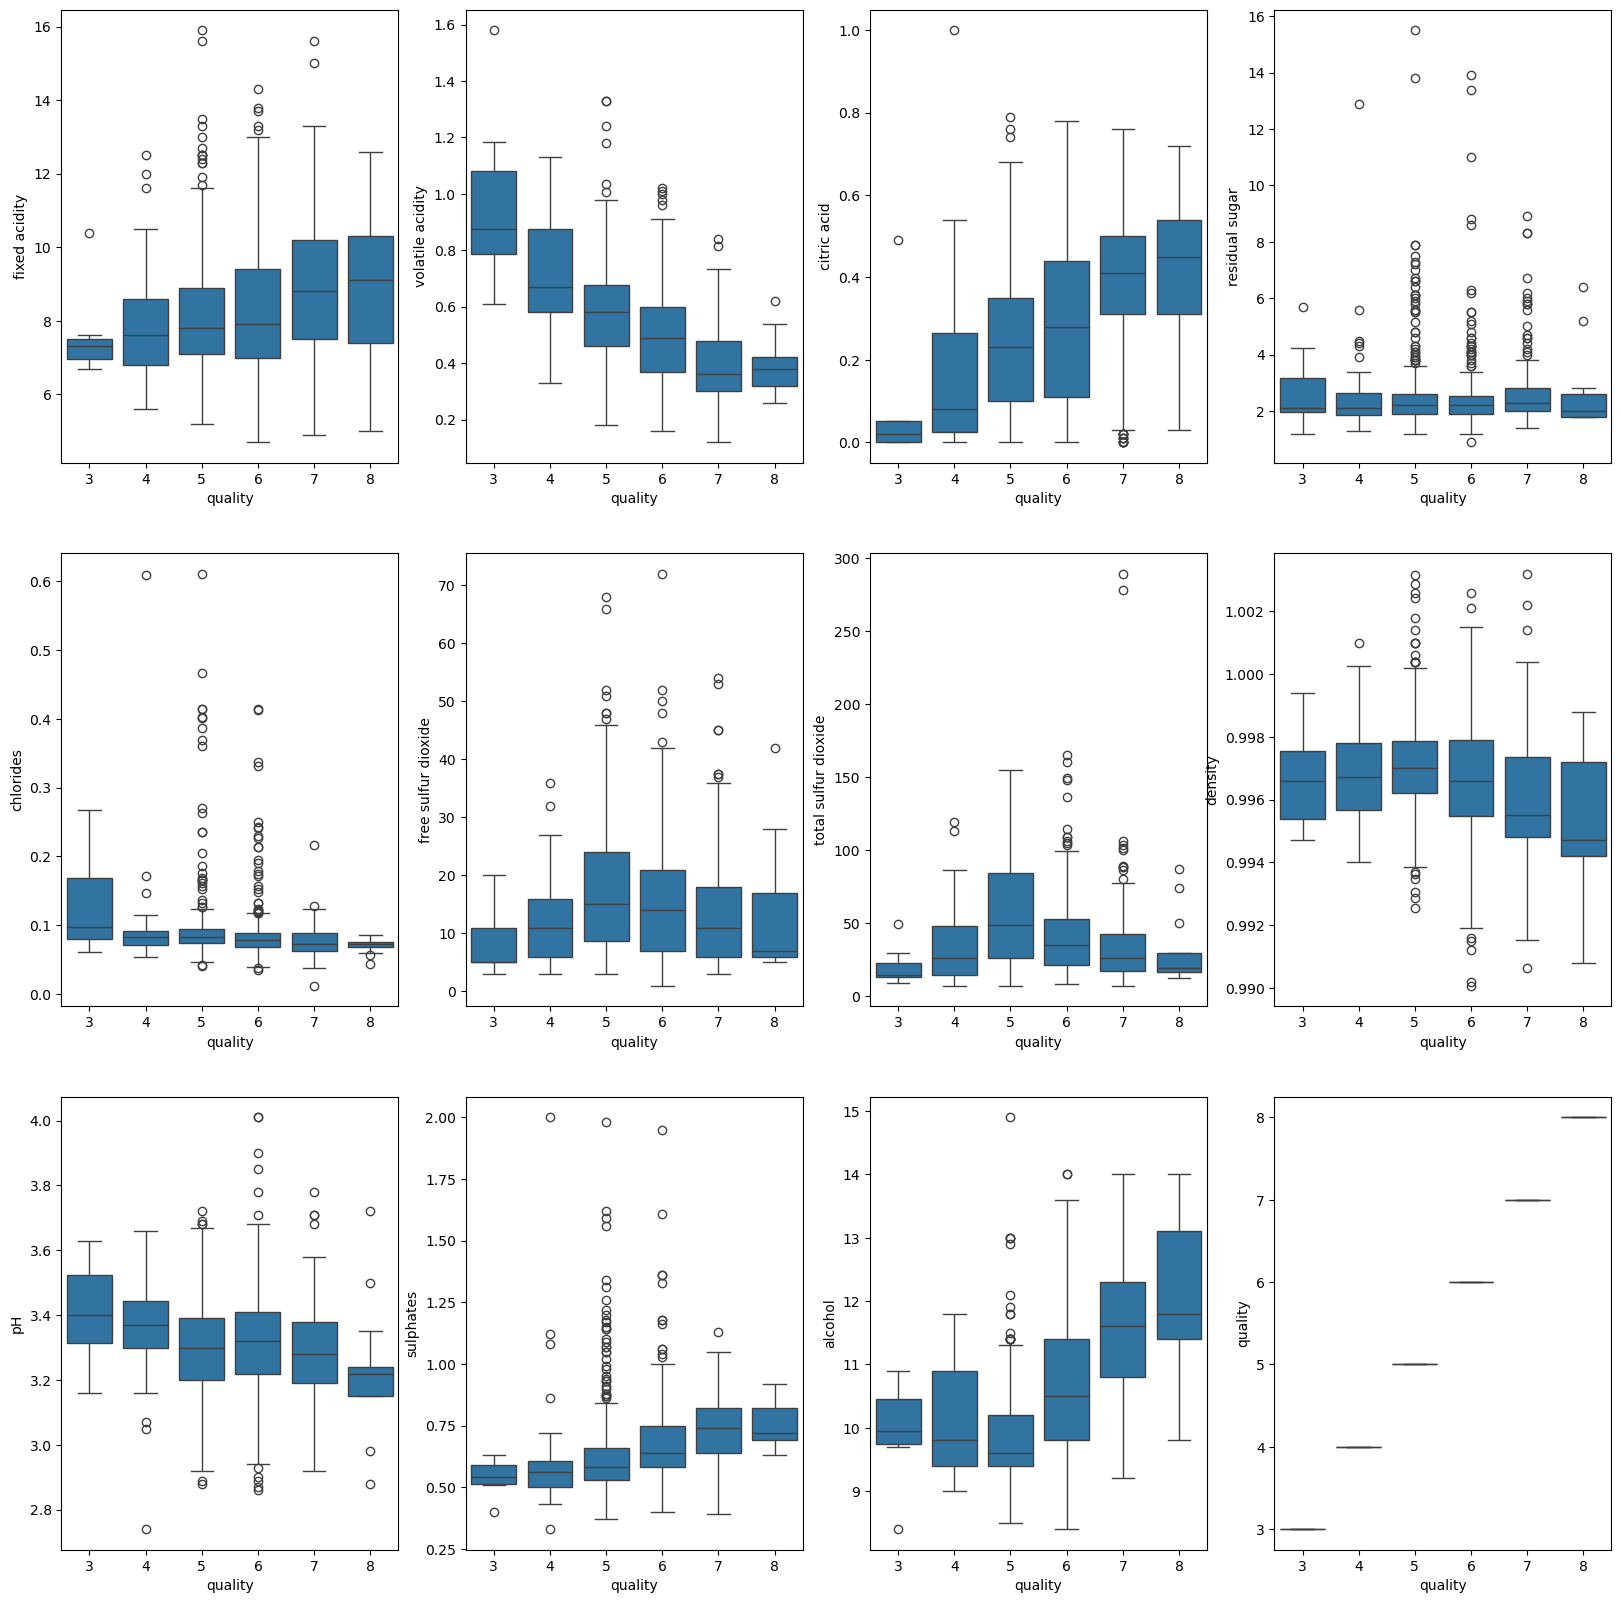

In [17]:
fig, axs = plt.subplots(3, 4, figsize=(20, 20))

for i, col in enumerate(train.columns):
    sns.boxplot(y=train[col], ax=axs[i//4, i%4], x=train['quality'])

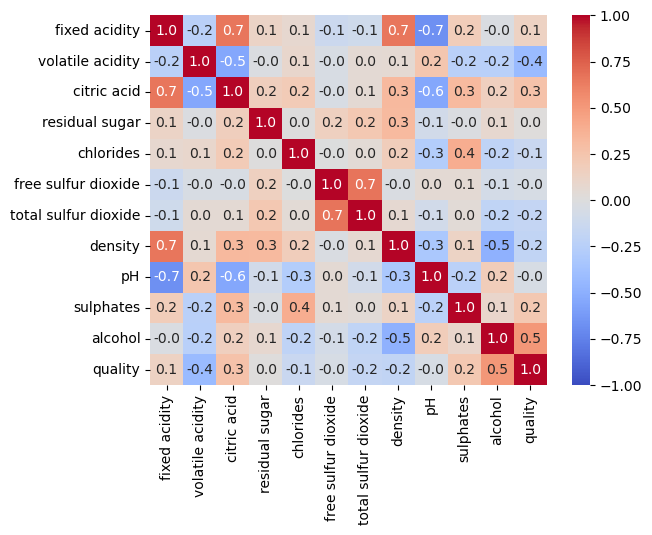

In [18]:
corr = train.corr()
sns.heatmap(corr,
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values, cmap="coolwarm", annot=True, fmt=".1f", vmin=-1, vmax=1);
#train = train.drop('residual sugar', axis=1) # удаление сильно коррелирующего признака

In [21]:
X = train.drop(['quality'], axis=1)
y = train['quality']

# stratify=y - нужен для сохранения баланса классов в обучающем и тест наборках
X_train,X_test,y_train,y_test=train_test_split(X, y, test_size=0.25, stratify=y)
X_test.shape 

(254, 11)

Удаление выбросов необходимо производить только на обучающем наборе. Решила удалить наблюдения, которые "улетели" за 1% и 99% квантили

In [24]:
# удаление выбросов

X_all = pd.concat([X_train, y_train],axis=1)
print('До удаления выбросов: ', X_all.shape)

col = X_all.columns.values
col = np.delete(col, np.where(col=='quality'))

for i in col:
    Q01 = X_all.groupby('quality')[i].quantile(0.01)
    Q99 = X_all.groupby('quality')[i].quantile(0.99)
    
    X_all = X_all[~((X_all[i] < X_all['quality'].map(Q01.to_dict()))) | (X_all[i] > X_all['quality'].map(Q99.to_dict()))]
print("После удаления выбросов: ", X_all.shape)

До удаления выбросов:  (761, 12)
После удаления выбросов:  (684, 12)


In [25]:
X_train = X_all.drop(['quality'], axis=1)
y_train = X_all['quality'].map({3:0, 4:0, 5:0, 6:0, 7:1, 8:1})
y_test = y_test.map({3:0, 4:0, 5:0, 6:0, 7:1, 8:1})

# Поиск модели

## KNN

In [104]:
cv = StratifiedKFold(n_splits=5, shuffle=True)

pipe = Pipeline([('preprocessing', MinMaxScaler()), 
                 ('classifier', KNeighborsClassifier())])

n_neighbors=[35,36,37,38,39,40]
p=[1,2,3,4,5]

param_grid =[
    {'preprocessing': [MinMaxScaler(), StandardScaler(),RobustScaler()], 
     'classifier': [KNeighborsClassifier(n_jobs=-1, weights='distance')],
     'classifier__n_neighbors': n_neighbors,
     'classifier__p': p
     }
]

grid = GridSearchCV(pipe, param_grid, cv=cv, scoring='precision', return_train_score=True, n_jobs=-1)
grid.fit(X_train,y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=True),
             estimator=Pipeline(steps=[('preprocessing', MinMaxScaler()),
                                       ('classifier', KNeighborsClassifier())]),
             n_jobs=-1,
             param_grid=[{'classifier': [KNeighborsClassifier(n_jobs=-1,
                                                              weights='distance')],
                          'classifier__n_neighbors': [35, 36, 37, 38, 39, 40],
                          'classifier__p': [1, 2, 3, 4, 5],
                          'preprocessing': [MinMaxScaler(), StandardScaler(),
                                            RobustScaler()]}],
             return_train_score=True, scoring='precision')

In [105]:
grid_result = pd.DataFrame(grid.cv_results_).sort_values(["rank_test_score",'std_test_score']).T
grid_result

,1,15,62,58,88,33,43,66,49,79,...,59,65,68,74,2,86,5,83,89,35
mean_fit_time,0.008002,0.008815,0.011009,0.007904,0.006404,0.009021,0.005504,0.00661,0.007821,0.014211,...,0.011714,0.01411,0.010623,0.011129,0.01221,0.011315,0.011023,0.010811,0.009307,0.014324
std_fit_time,0.000001,0.002502,0.001093,0.00128,0.000802,0.000973,0.000637,0.001196,0.000984,0.006558,...,0.001536,0.004,0.000972,0.001283,0.002107,0.000409,0.001061,0.000739,0.000397,0.003939
mean_score_time,0.039742,0.075746,0.052052,0.103587,0.105389,0.056423,0.113497,0.062342,0.056757,0.077548,...,0.103378,0.073569,0.098181,0.10777,0.042296,0.085211,0.083596,0.07604,0.085343,0.069623
std_score_time,0.005711,0.021376,0.016437,0.03428,0.038792,0.010431,0.025198,0.014531,0.013625,0.027796,...,0.0262,0.025695,0.020939,0.025373,0.011493,0.019221,0.032806,0.017249,0.021342,0.013524
param_classifier,"KNeighborsClassifier(n_jobs=-1, weights='dista...","KNeighborsClassifier(n_jobs=-1, weights='dista...","KNeighborsClassifier(n_jobs=-1, weights='dista...","KNeighborsClassifier(n_jobs=-1, weights='dista...","KNeighborsClassifier(n_jobs=-1, weights='dista...","KNeighborsClassifier(n_jobs=-1, weights='dista...","KNeighborsClassifier(n_jobs=-1, weights='dista...","KNeighborsClassifier(n_jobs=-1, weights='dista...","KNeighborsClassifier(n_jobs=-1, weights='dista...","KNeighborsClassifier(n_jobs=-1, weights='dista...",...,"KNeighborsClassifier(n_jobs=-1, weights='dista...","KNeighborsClassifier(n_jobs=-1, weights='dista...","KNeighborsClassifier(n_jobs=-1, weights='dista...","KNeighborsClassifier(n_jobs=-1, weights='dista...","KNeighborsClassifier(n_jobs=-1, weights='dista...","KNeighborsClassifier(n_jobs=-1, weights='dista...","KNeighborsClassifier(n_jobs=-1, weights='dista...","KNeighborsClassifier(n_jobs=-1, weights='dista...","KNeighborsClassifier(n_jobs=-1, weights='dista...","KNeighborsClassifier(n_jobs=-1, weights='dista..."
param_classifier__n_neighbors,35,36,39,38,40,37,37,39,38,40,...,38,39,39,39,35,40,35,40,40,37
param_classifier__p,1,1,1,5,5,2,5,3,2,2,...,5,2,3,5,1,4,2,3,5,2
param_preprocessing,StandardScaler(),MinMaxScaler(),RobustScaler(),StandardScaler(),StandardScaler(),MinMaxScaler(),StandardScaler(),MinMaxScaler(),StandardScaler(),StandardScaler(),...,RobustScaler(),RobustScaler(),RobustScaler(),RobustScaler(),RobustScaler(),RobustScaler(),RobustScaler(),RobustScaler(),RobustScaler(),RobustScaler()
params,"{'classifier': KNeighborsClassifier(n_jobs=-1,...","{'classifier': KNeighborsClassifier(n_jobs=-1,...","{'classifier': KNeighborsClassifier(n_jobs=-1,...","{'classifier': KNeighborsClassifier(n_jobs=-1,...","{'classifier': KNeighborsClassifier(n_jobs=-1,...","{'classifier': KNeighborsClassifier(n_jobs=-1,...","{'classifier': KNeighborsClassifier(n_jobs=-1,...","{'classifier': KNeighborsClassifier(n_jobs=-1,...","{'classifier': KNeighborsClassifier(n_jobs=-1,...","{'classifier': KNeighborsClassifier(n_jobs=-1,...",...,"{'classifier': KNeighborsClassifier(n_jobs=-1,...","{'classifier': KNeighborsClassifier(n_jobs=-1,...","{'classifier': KNeighborsClassifier(n_jobs=-1,...","{'classifier': KNeighborsClassifier(n_jobs=-1,...","{'classifier': KNeighborsClassifier(n_jobs=-1,...","{'classifier': KNeighborsClassifier(n_jobs=-1,...","{'classifier': KNeighborsClassifier(n_jobs=-1,...","{'classifier': KNeighborsClassifier(n_jobs=-1,...","{'classifier': KNeighborsClassifier(n_jobs=-1,...","{'classifier': KNeighborsClassifier(n_jobs=-1,..."
split0_test_score,0.75,0.5,1.0,0.75,1.0,0.625,0.666667,0.625,0.6,0.6,...,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0


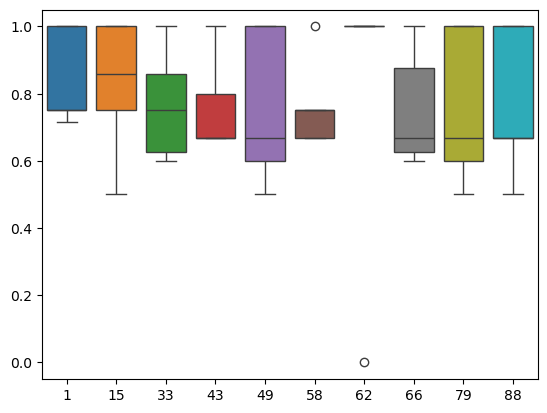

In [107]:
mask_0 = grid_result.index[grid_result.index.str.endswith("_test_score")][:-3]
tabl = grid_result.loc[mask_0].iloc[:,:10]
sns.boxplot(data=tabl);

In [109]:
model_KNN = Pipeline([('preprocessing', MinMaxScaler()), 
                 ('classifier', KNeighborsClassifier(n_jobs=-1, n_neighbors=36, p=1))])
model_KNN.fit(X_train, y_train)
y_pred_KNN = model_KNN.predict(X_test)

print('accuracy: ', model_KNN.score(X_test, y_test))
print('recall: ', recall_score(y_test, y_pred_KNN))
print('precision: ', precision_score(y_test, y_pred_KNN))

accuracy:  0.8740157480314961
recall:  0.08823529411764706
precision:  0.75


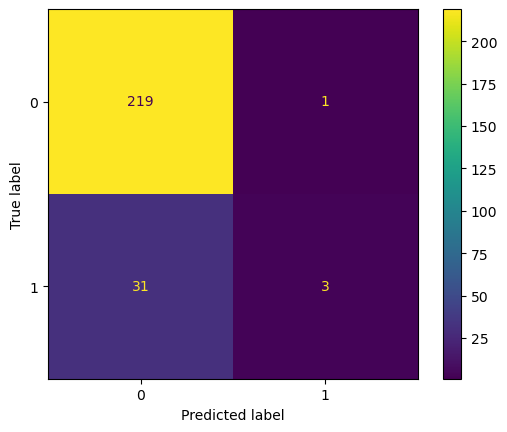

In [110]:
matrix_KNN =confusion_matrix(y_test,y_pred_KNN)

ConfusionMatrixDisplay(matrix_KNN).plot();

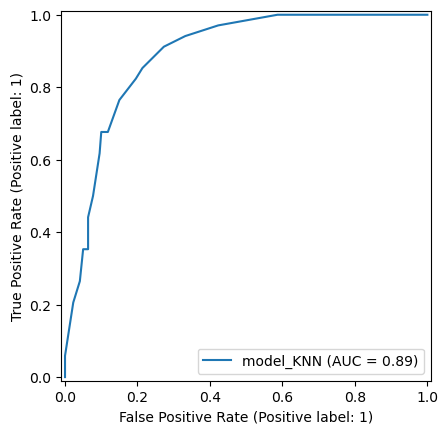

In [133]:
RocCurveDisplay.from_estimator(model_KNN, X_test, y_test, name = 'model_KNN');

## GNB

In [135]:
pipe = Pipeline([('preprocessing', MinMaxScaler()), 
                 ('clf',    GaussianNB())])

cv = StratifiedKFold(n_splits=5, shuffle=True)

param_grid =[
    {'preprocessing': [MinMaxScaler(), StandardScaler(),RobustScaler(), Normalizer()], 
     'clf': [GaussianNB()]}
    ]

grid = GridSearchCV(pipe, param_grid, cv = cv, scoring='precision')
grid.fit(X_train, y_train)

grid_result = pd.DataFrame(grid.cv_results_).sort_values(["rank_test_score",'std_test_score']).T
grid_result

,0,1,2,3
mean_fit_time,0.004201,0.004002,0.006004,0.003199
std_fit_time,0.000981,0.000634,0.001551,0.000983
mean_score_time,0.003,0.0036,0.0036,0.003203
std_score_time,0.000001,0.000801,0.000806,0.000403
param_clf,GaussianNB(),GaussianNB(),GaussianNB(),GaussianNB()
param_preprocessing,MinMaxScaler(),StandardScaler(),RobustScaler(),Normalizer()
params,"{'clf': GaussianNB(), 'preprocessing': MinMaxS...","{'clf': GaussianNB(), 'preprocessing': Standar...","{'clf': GaussianNB(), 'preprocessing': RobustS...","{'clf': GaussianNB(), 'preprocessing': Normali..."
split0_test_score,0.35,0.35,0.35,0.233333
split1_test_score,0.378378,0.378378,0.378378,0.307692
split2_test_score,0.46875,0.46875,0.46875,0.269231


In [138]:
model_GNB = Pipeline(steps=[('preprocessing', MinMaxScaler()), ('clf', GaussianNB())])
model_GNB.fit(X_train,y_train)
y_pred_GNB = model_GNB.predict(X_test)

print('precision: ', precision_score(y_test, y_pred_GNB))
print(classification_report(y_test, y_pred_GNB))

precision:  0.42105263157894735
              precision    recall  f1-score   support

           0       0.95      0.85      0.90       220
           1       0.42      0.71      0.53        34

    accuracy                           0.83       254
   macro avg       0.69      0.78      0.71       254
weighted avg       0.88      0.83      0.85       254



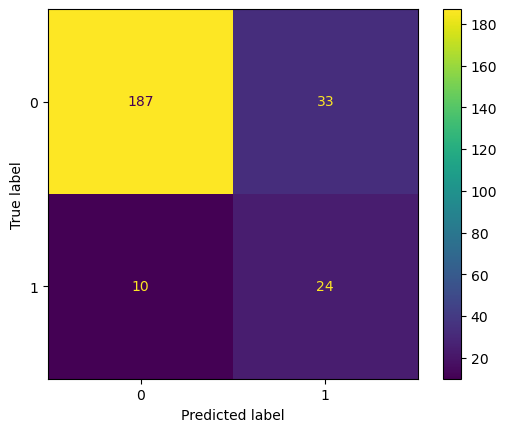

In [139]:
matrix_GNB =confusion_matrix(y_test,y_pred_GNB)
ConfusionMatrixDisplay(matrix_GNB).plot();

## LR

In [184]:
pipe = Pipeline([('preprocessing', MinMaxScaler()), 
                 ('clf',           LogisticRegression(max_iter=1500))])

cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=10)

scaling = [ MinMaxScaler(), StandardScaler(),RobustScaler(), Normalizer()]

param_grid =[
    {'preprocessing': scaling,'clf__penalty': ['l2'], 
         'clf__solver': ['newton-cg' ,'lbfgs', 'liblinear']},
    {'preprocessing': scaling,'clf__penalty': ['l1'], 
         'clf__solver': ['liblinear']},
    {'preprocessing': scaling,'clf__penalty': [None], 
         'clf__solver': ['lbfgs','newton-cg']}
    ]

grid = GridSearchCV(pipe, param_grid, scoring='roc_auc', cv = cv, return_train_score = True)
grid.fit(X_train, y_train)
 
grid_result = pd.DataFrame(grid.cv_results_).sort_values(["rank_test_score",'std_test_score']).T
grid_result

,14,13,0,4,12,2,6,9,10,1,...,20,22,17,18,23,19,3,7,11,15
mean_fit_time,0.005159,0.003601,0.004966,0.005343,0.003975,0.007402,0.006621,0.003464,0.005213,0.00536,...,0.005982,0.007356,0.00484,0.007059,0.008975,0.011588,0.004494,0.005402,0.003161,0.003862
std_fit_time,0.000417,0.00049,0.000483,0.000474,0.000511,0.000565,0.000525,0.000497,0.000413,0.000521,...,0.000316,0.000515,0.000462,0.000467,0.00146,0.001529,0.0005,0.000601,0.000367,0.00049
mean_score_time,0.002121,0.002201,0.00252,0.002361,0.0022,0.002414,0.002264,0.002212,0.00224,0.002281,...,0.002179,0.002322,0.002323,0.002384,0.002762,0.002486,0.00258,0.002503,0.002362,0.002322
std_score_time,0.000326,0.0004,0.000539,0.00048,0.000401,0.000487,0.000439,0.000402,0.000427,0.000449,...,0.000383,0.000466,0.000465,0.000484,0.000427,0.0005,0.000495,0.000497,0.000483,0.000465
param_clf__penalty,l1,l1,l2,l2,l1,l2,l2,l2,l2,l2,...,None,None,None,None,None,None,l2,l2,l2,l1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
split47_train_score,0.900419,0.90006,0.89404,0.894729,0.892243,0.899371,0.899341,0.899491,0.899042,0.899281,...,0.898383,0.898353,0.898383,0.898383,0.88817,0.885265,0.696107,0.696107,0.695807,0.688889
split48_train_score,0.891554,0.891734,0.886553,0.886553,0.886553,0.891285,0.891345,0.891794,0.890955,0.891494,...,0.891225,0.891375,0.891195,0.891554,0.871728,0.869152,0.681851,0.681821,0.681342,0.67658
split49_train_score,0.888328,0.888387,0.880651,0.88068,0.878141,0.889538,0.889361,0.889243,0.889155,0.889273,...,0.888387,0.888151,0.888269,0.88818,0.869578,0.86261,0.725633,0.725633,0.725987,0.727257
mean_train_score,0.897459,0.897607,0.890596,0.890666,0.889721,0.897545,0.897544,0.897751,0.897036,0.897578,...,0.896953,0.896947,0.896946,0.896938,0.885983,0.878442,0.704316,0.704255,0.704032,0.699242


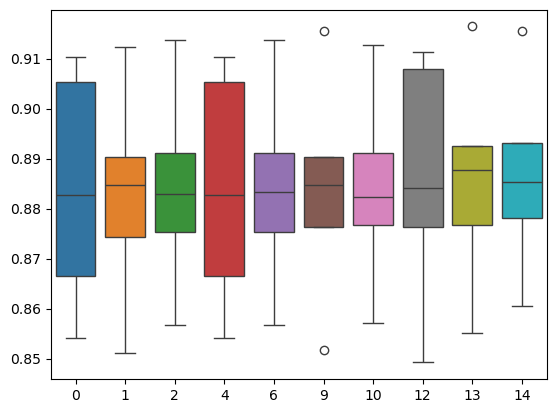

In [185]:
mask_1 = grid_result.index[grid_result.index.str.endswith("_test_score")][:-3]
tabl = grid_result.loc[mask_0].iloc[:,:10]
sns.boxplot(data=tabl);

In [186]:
grid.cv_results_['params'][0]

{'clf__penalty': 'l2',
 'clf__solver': 'newton-cg',
 'preprocessing': MinMaxScaler()}

In [187]:
model_LR = make_pipeline(MinMaxScaler(), LogisticRegression(solver = 'newton-cg', penalty = 'l2') )
model_LR.fit(X_train,y_train)

y_pred_LR = model_LR.predict(X_test)
y_pred_proba_LR = model_LR.predict_proba(X_test)[:,1]
print('precision: ', precision_score(y_test, y_pred_LR))
print(classification_report(y_test, y_pred_LR))

precision:  0.6666666666666666
              precision    recall  f1-score   support

           0       0.89      0.99      0.93       220
           1       0.67      0.18      0.28        34

    accuracy                           0.88       254
   macro avg       0.78      0.58      0.61       254
weighted avg       0.86      0.88      0.85       254



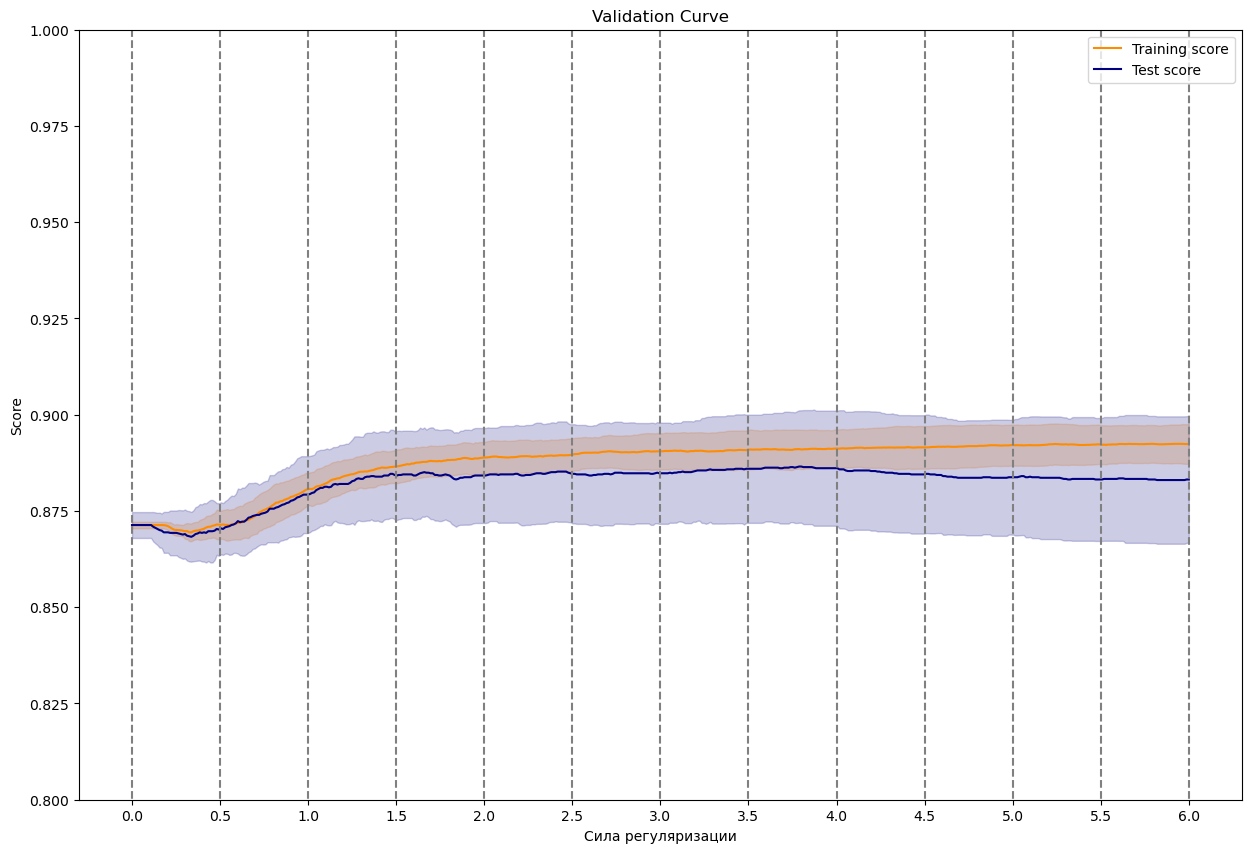

In [190]:
n_range = np.linspace(0.0001, 6, 500)
train_scores, test_scores = validation_curve(
    model_LR , X_train, y_train,
    param_name = "logisticregression__C", 
    param_range = n_range,
    cv = cv, 
    scoring='accuracy', 
    n_jobs=-1)

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.figure(figsize=(15,10))

plt.title("Validation Curve")
plt.xlabel("Сила регуляризации")
plt.ylabel("Score")
plt.ylim(0.8, 1)

plt.plot(n_range, train_scores_mean, label="Training score", color="darkorange")
plt.fill_between(n_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2,
                 color="darkorange")
plt.plot(n_range, test_scores_mean, label="Test score",
             color="navy")
plt.fill_between(n_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2,
                 color="navy")

plt.xticks(np.linspace(0, 6, 13))
for i in np.arange(0,6.5,0.5):
    plt.vlines(i, 0,1.2, linestyles='dashed', colors='gray')

plt.legend(loc="best")
plt.show();

In [192]:
model_LR_best = make_pipeline(MinMaxScaler(), LogisticRegression(solver = 'newton-cg', penalty = 'l2', C=1.7) )
model_LR_best.fit(X_train,y_train)

y_pred_LR_best = model_LR_best.predict(X_test)
y_pred_proba_LR_best = model_LR_best.predict_proba(X_test)[:,1]
print('accuracy: ', model_LR_best.score(X_train, y_train))
print('recall: ', recall_score(y_test, y_pred_LR_best))
print('precision: ', precision_score(y_test, y_pred_LR_best))
print(classification_report(y_test, y_pred_LR_best))

accuracy:  0.8888888888888888
recall:  0.17647058823529413
precision:  0.5454545454545454
              precision    recall  f1-score   support

           0       0.88      0.98      0.93       220
           1       0.55      0.18      0.27        34

    accuracy                           0.87       254
   macro avg       0.72      0.58      0.60       254
weighted avg       0.84      0.87      0.84       254



In [200]:
scorer = make_scorer(precision_score, zero_division=0)
model_tuned = TunedThresholdClassifierCV(estimator = model_LR_best, scoring=scorer)

cv_results_model_tuned = pd.DataFrame(
    cross_validate(
        model_tuned,
        X_train,
        y_train,
        scoring=scorer,
        cv=RepeatedStratifiedKFold(n_splits=5, n_repeats=10),
        return_train_score=True,
        return_estimator=True,
    )
)

median:  0.5319240766810667
mean:  0.5310330365622995


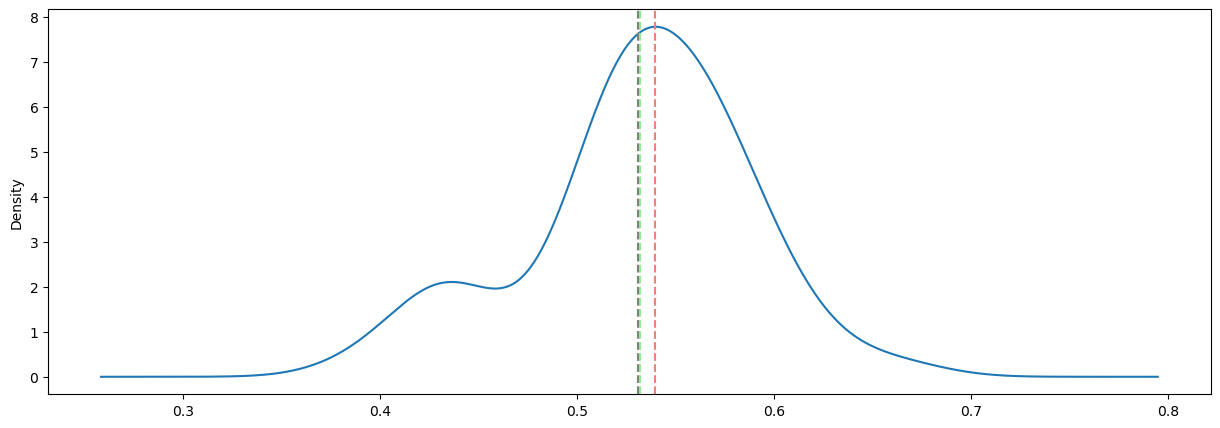

In [197]:
decision_threshold = pd.Series([est.best_threshold_ for est in cv_results_model_tuned["estimator"]])#

fig, ax = plt.subplots(figsize=(15,5))

ax = decision_threshold.plot.kde(bw_method=None) # w_method=0.4
line = ax.get_lines() 
x_plt, y_plt = line[0].get_data()
ths = {
    'mode':   [x_plt[np.argmax(y_plt)],'lightcoral'],
    'median': [decision_threshold.median(), 'lightgreen'],
    'mean':   [decision_threshold.mean(),  'gray']
}
for key in ths.keys():
    ax.axvline(
        ths[key][0],
        color=ths[key][1],
        linestyle="--",
        label=f"{key} decision threshold: {ths[key][0]:.5f}",
    )
print('median: ', decision_threshold.median())
print('mean: ', decision_threshold.mean())

precision:  0.6666666666666666
              precision    recall  f1-score   support

           0       0.89      0.99      0.93       220
           1       0.67      0.18      0.28        34

    accuracy                           0.88       254
   macro avg       0.78      0.58      0.61       254
weighted avg       0.86      0.88      0.85       254



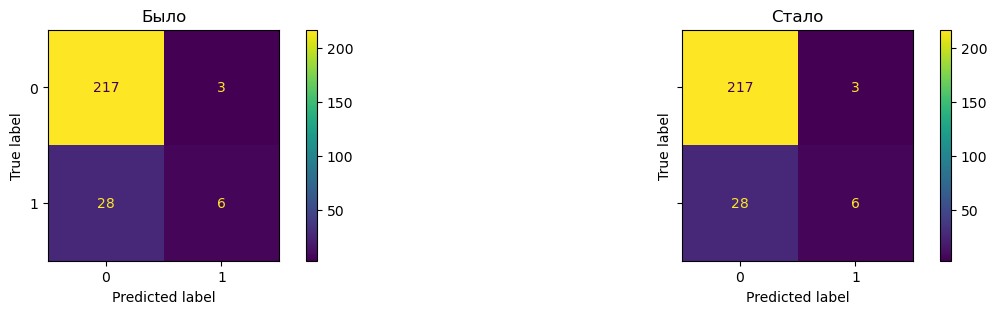

In [202]:
best_y_pred_LR_best = (y_pred_proba_LR_best > decision_threshold.mean()).astype(int)

matrix_LR =confusion_matrix(y_test,y_pred_LR)
matrix_LR_best =confusion_matrix(y_test, best_y_pred_LR_best)

fig, [ax1, ax2] = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(15,3))

ConfusionMatrixDisplay(matrix_LR).plot(ax = ax1);
ConfusionMatrixDisplay(matrix_LR_best).plot(ax = ax2);

ax1.set_title('Было')
ax2.set_title("Стало")

print('precision: ', precision_score(y_test, best_y_pred_LR_best))
print(classification_report(y_test, best_y_pred_LR_best))

## SVM

### rbf

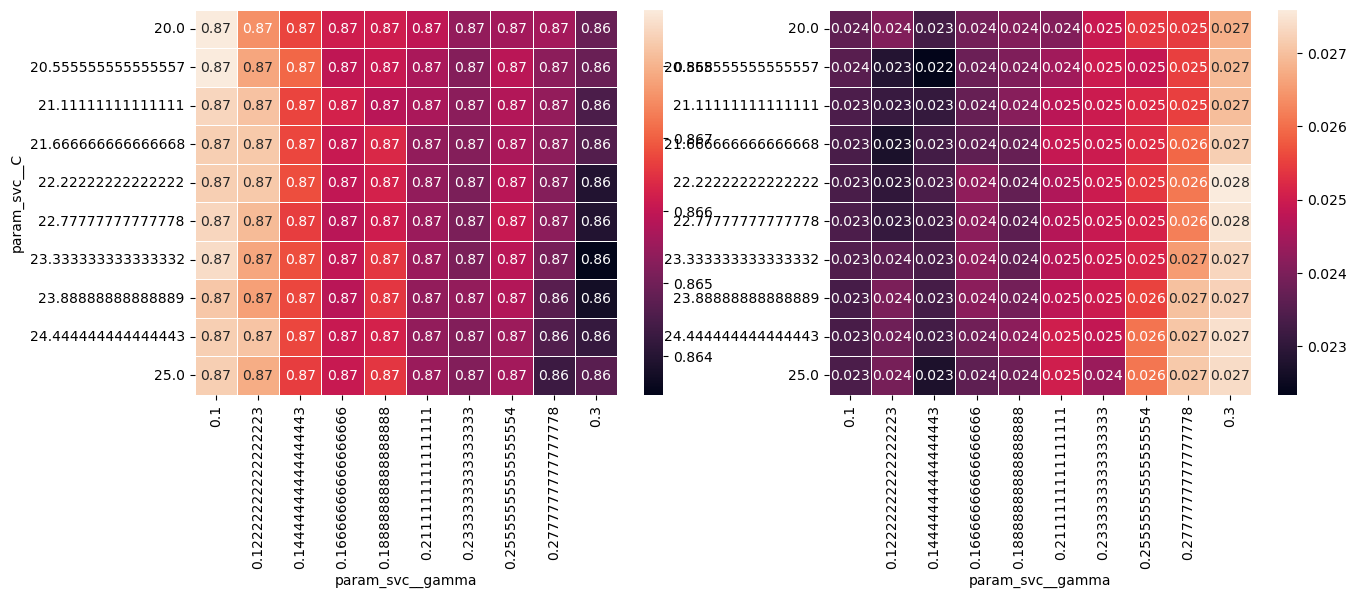

In [210]:
pipe = make_pipeline(MinMaxScaler(), SVC(kernel='rbf')) 
pipe.fit(X_train, y_train)
y_predict = pipe.predict(X_test)

cv = StratifiedKFold(n_splits=5, shuffle=True)

C= np.linspace(20, 25, 10) #np.array([0.01,0.1,1,10,100,10**3,10**4, 10**5,10**6,10**7])
gamma= np.linspace(0.1, 0.3, 10) #[0.01,0.1,1,5,10,100]

param_grid =[
    {'minmaxscaler': [MinMaxScaler()], 
     'svc': [svm.SVC(kernel='rbf')],
     'svc__C': C,
     'svc__gamma': gamma
     }
]

grid = GridSearchCV(pipe, param_grid, scoring='roc_auc', cv=cv, return_train_score=True)
grid.fit(X_train,y_train)

grid_result = pd.DataFrame(grid.cv_results_).sort_values(["rank_test_score",'std_test_score'])

pv_grid_result_mean = grid_result.pivot_table(index='param_svc__C',columns='param_svc__gamma',values='mean_test_score')
pv_grid_result_std = grid_result.pivot_table(index='param_svc__C',columns='param_svc__gamma',values='std_test_score')

f, (ax1, ax2) = plt.subplots(1,2,figsize=(15, 5))
sns.heatmap(pv_grid_result_mean, annot=True, linewidths=.5, ax=ax1, fmt=".2f")
sns.heatmap(pv_grid_result_std, annot=True, linewidths=.5, ax=ax2);

In [212]:
model_SVM_rbf = make_pipeline(MinMaxScaler(), SVC(C=23, gamma=0.2, probability=True)) #, probability=True))
model_SVM_rbf.fit(X_train, y_train)

y_pred_SVM_rbf = model_SVM_rbf.predict(X_test)
y_pred_proba_SVM_rbf =  model_SVM_rbf.predict_proba(X_test)[:, 1]
print('precision: ', precision_score(y_test, y_pred_SVM_rbf))
print(classification_report(y_test, y_pred_SVM_rbf))

precision:  1.0
              precision    recall  f1-score   support

           0       0.88      1.00      0.94       220
           1       1.00      0.15      0.26        34

    accuracy                           0.89       254
   macro avg       0.94      0.57      0.60       254
weighted avg       0.90      0.89      0.85       254



### poly

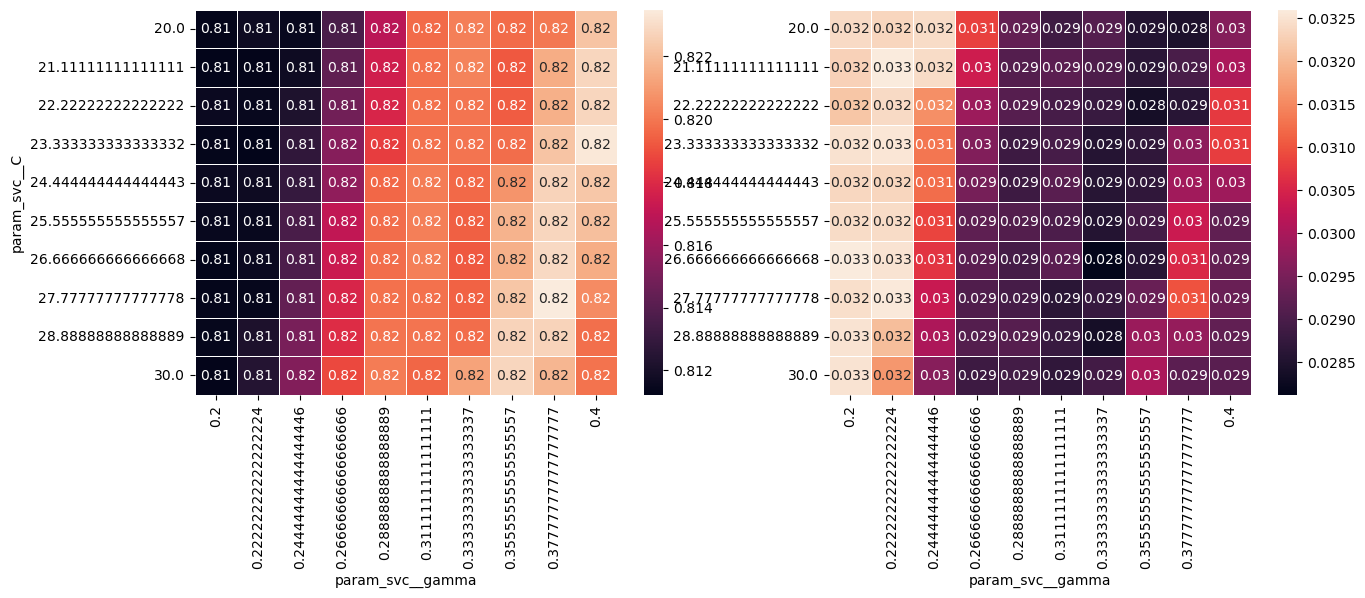

In [221]:
pipe = make_pipeline(MinMaxScaler(), SVC(kernel='poly'))
pipe.fit(X_train, y_train)
y_predict = pipe.predict(X_test)

cv = StratifiedKFold(n_splits=5, shuffle=True)

C= np.linspace(20, 30, 10)
gamma= np.linspace(0.2,0.4, 10)

param_grid =[
    {'minmaxscaler': [MinMaxScaler()], 
     'svc': [svm.SVC(kernel='poly')],
     'svc__C': C,
     'svc__gamma': gamma
     }
]

grid = GridSearchCV(pipe, param_grid, scoring='roc_auc', cv=cv, return_train_score=True) #scoring='f1'
grid.fit(X_train,y_train)

grid_result = pd.DataFrame(grid.cv_results_).sort_values(["rank_test_score",'std_test_score'])

pv_grid_result_mean = grid_result.pivot_table(index='param_svc__C',columns='param_svc__gamma',values='mean_test_score')
pv_grid_result_std = grid_result.pivot_table(index='param_svc__C',columns='param_svc__gamma',values='std_test_score')

f, (ax1, ax2) = plt.subplots(1,2,figsize=(15, 5))
sns.heatmap(pv_grid_result_mean, annot=True, linewidths=.5, ax=ax1, fmt=".2f")
sns.heatmap(pv_grid_result_std, annot=True, linewidths=.5, ax=ax2);

In [223]:
model_SVM_poly = make_pipeline(MinMaxScaler(), SVC(C=28, gamma=0.33, probability=True))
model_SVM_poly.fit(X_train, y_train)

y_pred_SVM_poly = model_SVM_poly.predict(X_test)
y_pred_proba_SVM_poly = model_SVM_poly.predict_proba(X_test)[:, 1]
print('precision: ', precision_score(y_test, y_pred_SVM_poly))
print(classification_report(y_test, y_pred_SVM_poly))

precision:  0.7058823529411765
              precision    recall  f1-score   support

           0       0.91      0.98      0.94       220
           1       0.71      0.35      0.47        34

    accuracy                           0.89       254
   macro avg       0.81      0.67      0.71       254
weighted avg       0.88      0.89      0.88       254



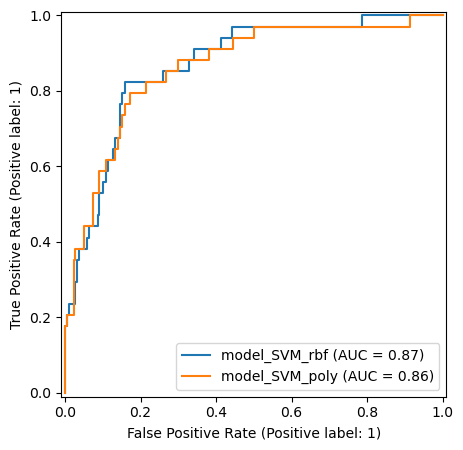

In [224]:
fig, ax_roc = plt.subplots(1,1, figsize=(10, 5))
RocCurveDisplay.from_estimator(model_SVM_rbf, X_test, y_test, ax = ax_roc, name = 'model_SVM_rbf');
RocCurveDisplay.from_estimator(model_SVM_poly, X_test, y_test, ax = ax_roc, name = 'model_SVM_poly');